# Importing necessary libraries

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Input, Activation, Permute, LSTM, Dropout, add, dot, concatenate, Dense

from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package punkt to /home/huda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data

In [2]:
# readind in data from text files
with open("tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_train.txt", 'rb') as f:
    train_data = f.read()
    
with open("tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_test.txt", 'rb') as f:
    test_data = f.read()

In [3]:
# function to flatten story-lines from individual lists to one list per story 
flatten = lambda text_list: [j for i in text_list for j in i]

In [4]:
def data_parser(data):
    """
        Takes in data as input of type bytes, decodes it and
        split into tuple of form (story, question, answer)
    """
    
    # byte decoding
    data = test_data.decode('utf-8').split("\n")
    
    # list to store data in form of tuples
    extracted_data = []
    
    # SINGLE-STORY-STORAGE:list to store story lines of one story at a time
    last_visited_story = []
    
    # visiting every line in data one at a time
    for line in data:
        
        # continuing only if line has a valid data in it
        if line != "":
            # each line is splitted into line#( per story) and story-line
            story_line_num, story_line = line.split(' ',1)
            story_line_num = int(story_line_num)

            # start of new story
            if story_line_num == 1:
                
                # nulling the story list for storing upcoming story
                last_visited_story = []

            # the presence of query(/question)-answer pair
            if '\t' in story_line:
                
                #splitting query-answer pair
                query, answer, supported_fact_id = story_line.split("\t")

                # gathering the list of stories into single list from SINGLE-STORY-STORAGE
                story_lines = [i for i in last_visited_story if i!=None]
                
                # flattening them into single list of story with individual tokens
                story_lines = flatten(story_lines)
                
                # tokenizing query and appending the tuple to data
                extracted_data.append((story_lines, word_tokenize(query), answer))
            
            # story being continued
            else:
                # tokenizing the story-line and appending to current story in SINGLE-STORY-STORAGE
                last_visited_story.append(word_tokenize(story_line))
    
    # data ready to analyze
    return extracted_data

In [5]:
# parsing byte-encoded data into data_parser to get data in desired format for further analysis

train_data = data_parser(train_data)
test_data = data_parser(test_data)

# Exploring the Data format

In [6]:
len(train_data), type(train_data)

(1000, list)

In [7]:
# train_data[0]

In [8]:
len(train_data[0])

3

In [9]:
# STORY
single_example = train_data[22]

print(f"STORY:\n{' '.join(single_example[0])}\n")
print(f"QUESTION:\n{' '.join(single_example[1])}\n")
print(f"ANSWER:\n{single_example[2]}\n")

STORY:
Mary moved to the kitchen . Mary travelled to the office . Daniel grabbed the football there . Mary moved to the hallway . Sandra moved to the bedroom . Mary went back to the bedroom . John grabbed the milk there . John put down the milk . Daniel journeyed to the bathroom . Sandra journeyed to the bathroom . John got the milk there . Mary took the apple there . Mary left the apple . John journeyed to the bedroom . Mary travelled to the office . Daniel put down the football . John went back to the kitchen . Sandra got the football there . John travelled to the hallway . Sandra discarded the football there .

QUESTION:
Where is the football ?

ANSWER:
bathroom



# Creating a vocabulary

In [10]:
# vocabulary consists of all the tokens from train and test data

all_data = test_data + train_data

In [11]:
len(all_data)

2000

In [12]:
# getting individual lengths of stories and queries

all_stories_len = [len(data[0]) for data in all_data]
all_questions_len = [len(data[1]) for data in all_data]

In [13]:
# LENGTH OF LONGEST STORY & QUERY

max_story_len = max(all_stories_len)
max_question_len = max(all_questions_len)

In [14]:
max_story_len, max_question_len

(552, 5)

In [15]:
# building up vocabulary from the set of all the tokens of stories and queries.
vocab = set()
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [16]:
len(vocab)

35

In [17]:
# padding for masking(used later)

vocab_len = len(vocab) + 1

# Vectorization

In [18]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [19]:
# tokenizer.index_word

In [20]:
def vectorize_stories(data,
                     word_index=tokenizer.word_index,
                     max_story_len=max_story_len,
                     max_question_len=max_question_len):
    """
        Takes in data of raw tuples of story, query, answer in token format.
        Converts each tokens to word ID from corresponding vocabulary,
        pads the sequences upto the corresponding maximum seq in stories and queries
        @returns: tuple of padded sequences of word IDs of story, query and answer
    """
    
    X = [] # STORIES Vector
    Xq = [] # QUERIES Vector
    Y = [] # ANSWERS Vector
    
    for story, question, answer in data:
        # generating list of word IDs of current story
        x = [word_index[word.lower()] for word in story]
        
        # generating list of word IDs of current query
        xq = [word_index[word.lower()] for word in question]
        
        # array to hold answer, it will be of size equal vocab plus one for padding
        y = np.zeros(len(word_index) + 1)
        
        # putting 1 for the answer label at corresponding word index
        y[word_index[answer]] = 1
        
        # putting back results
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # padding of story,query upto their maximum sequences
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [21]:
# vectorzing stories, queries and corresponding answers of train/test data using vocab 
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [22]:
# queries_test

# Build the Network 

In [23]:
vocab_size = len(vocab) + 1

In [24]:
# PLACEHOLDERS to define network computational graph

# input sequence to encoder M and encoder C
input_sequence = Input(shape=(max_story_len,))

# input sequence to question encoder
question = Input(shape=(max_question_len,))

## Input Ecoder M

In [25]:
# encoder to embedd the input sequences into embedded sequence vectors

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# OUTPUT -----> (samples, story_maxlen, embedding_dim)

## Input Encoder C

In [26]:
# encoder to embedd the input sequences into embedded sequence vectors of dim equals to max query len

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# OUTPUT -----> (samples, story_maxlen, max_question_len)

## Question Encoder

In [27]:
# encoder to embedd the query into sequence of embedded vector

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# (samples, query_maxlen, embedding_dim)

## Sequence Encodings

In [28]:
# embedding the input sequence(os stories) in the form of word indices 
# into sequence of dense vectors using Encoder M and Encoder C
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)

# embedding the sequences of word indices of questions into
# sequence of dense vectors using Question Encoder
question_encoded = question_encoder(question)

## Model Architecture

In [29]:
# match between to input vector sequence and question vector 
# sequences and applying softmax to get attention scores 
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

# summing up the match score matrix and input vector sequence
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

# concatenating the response vector with the question vector sequence
answer = concatenate([response, question_encoded])

# feeding to RNN
answer = LSTM(units=32)(answer)
answer = Dropout(0.5)(answer) # for regularization effect
answer = Dense(units=vocab_size)(answer) # getting output

# applying softmax to get probability dist. over the vocabulary  
answer = Activation('softmax')(answer)

In [34]:
# building model

model = Model([input_sequence, question], answer)

In [35]:
# compiling

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 552)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2304      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 5, 64)                2304      ['input_2[0][0]']             
                                                                                              

# Model Training

In [36]:
# training over train sequences

model.fit([inputs_train, queries_train], answers_train, 
          batch_size=32, 
          epochs=150,
          validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/150
32/32 [==============================] - 4s 58ms/step - loss: 1.5550 - accuracy: 0.3730 - val_loss: 1.4333 - val_accuracy: 0.5110
Epoch 2/150
32/32 [==============================] - 1s 37ms/step - loss: 1.5282 - accuracy: 0.3890 - val_loss: 1.4158 - val_accuracy: 0.5020
Epoch 3/150
32/32 [==============================] - 1s 33ms/step - loss: 1.5032 - accuracy: 0.4120 - val_loss: 1.3979 - val_accuracy: 0.5080
Epoch 4/150
32/32 [==============================] - 1s 32ms/step - loss: 1.5111 - accuracy: 0.3950 - val_loss: 1.3844 - val_accuracy: 0.5140
Epoch 5/150
32/32 [==============================] - 1s 33ms/step - loss: 1.5025 - accuracy: 0.4140 - val_loss: 1.3742 - val_accuracy: 0.5350
Epoch 6/150
32/32 [==============================] - 1s 32ms/step - loss: 1.4605 - accuracy: 0.4400 - val_loss: 1.3578 - val_accuracy: 0.5330
Epoch 7/150
32/32 [==============================] - 1s 32ms/step - loss: 1.4514 - accuracy: 0.4380 - val_loss: 1.3447 - val_accuracy: 0.5180
Epoch 

32/32 [==============================] - 1s 32ms/step - loss: 0.4816 - accuracy: 0.8240 - val_loss: 0.1549 - val_accuracy: 0.9710
Epoch 116/150
32/32 [==============================] - 1s 32ms/step - loss: 0.5000 - accuracy: 0.8220 - val_loss: 0.1424 - val_accuracy: 0.9850
Epoch 117/150
32/32 [==============================] - 1s 32ms/step - loss: 0.4784 - accuracy: 0.8290 - val_loss: 0.1703 - val_accuracy: 0.9670
Epoch 118/150
32/32 [==============================] - 1s 32ms/step - loss: 0.4876 - accuracy: 0.8230 - val_loss: 0.1389 - val_accuracy: 0.9810
Epoch 119/150
32/32 [==============================] - 1s 32ms/step - loss: 0.4409 - accuracy: 0.8370 - val_loss: 0.1378 - val_accuracy: 0.9790
Epoch 120/150
32/32 [==============================] - 1s 32ms/step - loss: 0.4502 - accuracy: 0.8450 - val_loss: 0.1553 - val_accuracy: 0.9730
Epoch 121/150
32/32 [==============================] - 1s 32ms/step - loss: 0.4591 - accuracy: 0.8460 - val_loss: 0.1489 - val_accuracy: 0.9700
Epoch 

# Training History

In [37]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

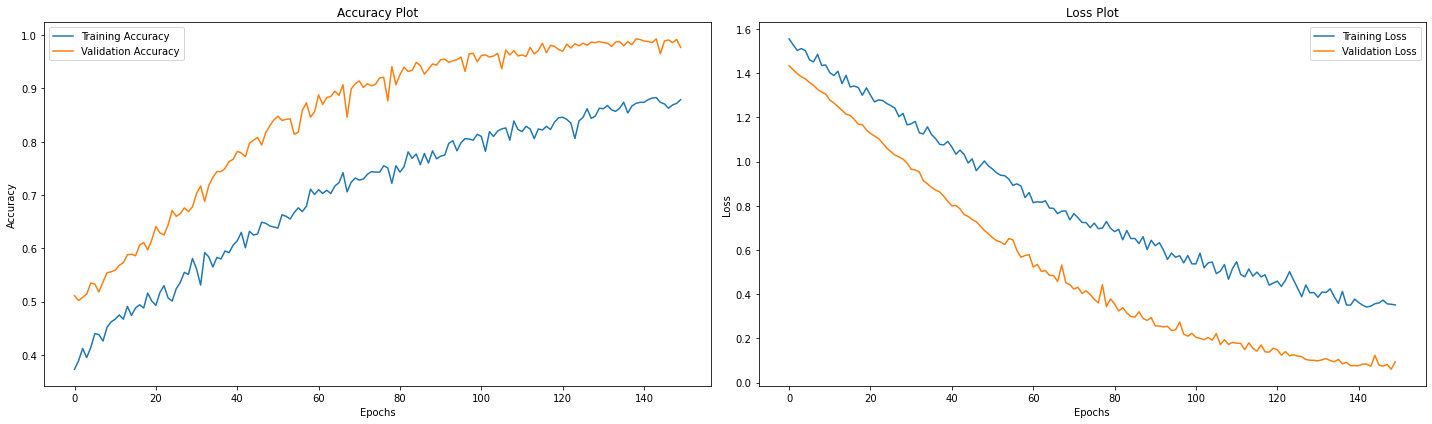

In [38]:
fig, axes = plt.subplots(1,2, figsize=(20,6))
axes[0].plot(model.history.history['accuracy'], label="Training Accuracy")
axes[0].plot(model.history.history['val_accuracy'], label="Validation Accuracy")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].plot(model.history.history['loss'], label="Training Loss")
axes[1].plot(model.history.history['val_loss'], label="Validation Loss")
axes[1].set_title("Loss Plot")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()

# Model Evaluation

In [78]:
# predictions over the stories-query pairs from test data

for i in range(10,15):
    print(i)
    story = test_data[i][0]
    query = test_data[i][1]
    answer = test_data[i][2]
    
    story_seq, query_seq, _ = vectorize_stories(data = [test_data[i]])
    
    prediction = model.predict([story_seq, query_seq], verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_answer = tokenizer.index_word[predicted_index]
    
    print("Story: ", ' '.join(story))
    print("Query: ",  ' '.join(query))
    print("Answer: ",  answer)
    print("Predicted Answer: ",  predicted_answer)
    print("\n\n")

10
Story:  Mary picked up the apple there . Mary dropped the apple . Daniel went back to the garden . Mary journeyed to the office . John got the football there . Mary went back to the kitchen . Daniel picked up the milk there . John travelled to the bedroom .
Query:  Where is the football ?
Answer:  bedroom
Predicted Answer:  bedroom



11
Story:  Mary picked up the apple there . Mary dropped the apple . Daniel went back to the garden . Mary journeyed to the office . John got the football there . Mary went back to the kitchen . Daniel picked up the milk there . John travelled to the bedroom . John moved to the hallway . John discarded the football .
Query:  Where is the football ?
Answer:  hallway
Predicted Answer:  hallway



12
Story:  Mary picked up the apple there . Mary dropped the apple . Daniel went back to the garden . Mary journeyed to the office . John got the football there . Mary went back to the kitchen . Daniel picked up the milk there . John travelled to the bedroom . J

In [79]:
model.save("MemN2N.h5")

/home/huda/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


`THE END`